In [2]:
import pandas as pd
from collections import defaultdict
from time import time
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD, NMF
import warnings
warnings.filterwarnings('ignore')

# pd.set_option("max_colwidth", None)
pd.reset_option('^display.', silent=True)

### 1. <font color='red'>Gather Data </font>

In [3]:


categories = [
    "sci.space",
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics"    
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories, ## Comment to get 20 categories
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


In [57]:
target_dict = {}
for k,v in zip(np.unique(dataset.target), dataset.target_names):
    target_dict[k] = v
targe_df = pd.DataFrame(target_dict.items(), columns=["target", "target_names"])

df = pd.DataFrame(dataset.data, columns=["Text"]).copy()
df["act_target"] = dataset.target
df["act_target_names"] = list(map(lambda x : target_dict[x], df.act_target))

pd.set_option("max_colwidth", None)
df.head()

Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [58]:
pd.reset_option('^display.', silent=True)

### 2. <font color='red'>K-means clustering on text features </font>

METRICS to consider : <br>

a) <font color="blue"><b>homogeneity</font></b> : which quantifies how much clusters contain only members of a single class; <br>
b) <font color="blue"><b>completeness</font></b> : which quantifies how much members of a given class are assigned to the same clusters;<br>
c) <font color="blue"><b>V-measure</font></b>  : the harmonic mean of completeness and homogeneity;<br>
d) <font color="blue"><b>Rand-Index</font></b> : which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment;<br>
e) <font color="blue"><b>Adjusted Rand-Index </font></b> : a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation.

In [59]:
evaluations = []
evaluations_std = []

def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

Two feature extraction methods are being used:

TfidfVectorizer uses an in-memory vocabulary (a Python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.

HashingVectorizer hashes word occurrences to a fixed dimensional space, possibly with collisions. The word count vectors are then normalized to each have l2-norm equal to one (projected to the euclidean unit-sphere) which seems to be important for k-means to work in high dimensional space.

Furthermore it is possible to post-process those extracted features using dimensionality reduction. We will explore the impact of those choices on the clustering quality in the following.

<font color="blue">KMeans </font>- Trial & Hit

In [60]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df["Text"])

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

vectorization done in 0.381 s
n_samples: 3387, n_features: 7929
0.007


<font color="blue"><b>Note</font></b> : After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5), the resulting number of unique terms n_features is around 8,000. We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries divided by the total number of elements.<br>
We find that around 0.7% of the entries of the X_tfidf matrix are non-zero.

In [61]:
store = []
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=5,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes} ; Seed:{seed}")
    store.append(cluster_sizes)
print()
print(f"Mean : {list(pd.DataFrame(store).mean())}")
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [ 653  489  436 1809] ; Seed:0
Number of elements assigned to each cluster: [1747  612  580  448] ; Seed:1
Number of elements assigned to each cluster: [ 455 1770  755  407] ; Seed:2
Number of elements assigned to each cluster: [ 521 1742  399  725] ; Seed:3
Number of elements assigned to each cluster: [ 711 1868  506  302] ; Seed:4

Mean : [817.4, 1296.2, 535.2, 738.2]
True number of documents in each category according to the class labels: [799 973 987 628]


In [62]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.17 ± 0.03 s 
Homogeneity: 0.351 ± 0.006
Completeness: 0.402 ± 0.012
V-measure: 0.375 ± 0.008
Adjusted Rand-Index: 0.207 ± 0.015
Silhouette Coefficient: 0.007 ± 0.000


All those clustering evaluation metrics have a maximum value of 1.0 (for a perfect clustering result). Higher values are better. Values of the Adjusted Rand-Index close to 0.0 correspond to a random labeling. Notice from the scores above that the cluster assignment is indeed well above chance level, but the overall quality can certainly improve.

Keep in mind that the class labels may not reflect accurately the document topics and therefore metrics that use labels are not necessarily the best to evaluate the quality of our clustering pipeline.

### 3. <font color="red">Predicted Labels</font>

In [63]:
df["pred_target"] = kmeans.labels_
df["pred_target_names"] = list(map(lambda x : target_dict[x], df.pred_target))
df.head(10)

,Text,act_target,act_target_names,pred_target,pred_target_names
0,My point is that you set up your views as the ...,0,alt.atheism,1,comp.graphics
1,\nBy '8 grey level images' you mean 8 items of...,1,comp.graphics,0,alt.atheism
2,FIRST ANNUAL PHIGS USER GROUP CONFERENCE\n\n ...,1,comp.graphics,0,alt.atheism
3,"I responded to Jim's other articles today, but...",3,talk.religion.misc,1,comp.graphics
4,"\nWell, I am placing a file at my ftp today th...",1,comp.graphics,0,alt.atheism
5,\nI'm also interested in info both public doma...,1,comp.graphics,0,alt.atheism
6,\n\n\n\tThey did the rollout already??!? I am...,2,sci.space,1,comp.graphics
7,George William Herbert sez:\n\n\nI like your o...,2,sci.space,1,comp.graphics
8,"From the ""JPL Universe""\nApril 23, 1993\n\nVLB...",2,sci.space,2,sci.space
9,"\n]The ""corrupted over and over"" theory is pr...",0,alt.atheism,3,talk.religion.misc


### 4. <font color="red">Dimensionality Reduction</font>

A n_init=1 can still be used as long as the dimension of the vectorized space is reduced first to make k-means more stable. For such purpose we use TruncatedSVD, which works on term count/tf-idf matrices. Since SVD results are not normalized, we redo the normalization to improve the KMeans result. Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.

In [64]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.503 s
Explained variance of the SVD step: 18.4%


In [11]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.01 ± 0.00 s 
Homogeneity: 0.403 ± 0.004
Completeness: 0.447 ± 0.013
V-measure: 0.424 ± 0.006
Adjusted Rand-Index: 0.317 ± 0.017
Silhouette Coefficient: 0.030 ± 0.002


We can observe that clustering on the LSA representation of the document is significantly faster (both because of n_init=1 and because the dimensionality of the LSA feature space is much smaller). Furthermore, all the clustering evaluation metrics have improved. We repeat the experiment with MiniBatchKMeans.

In [12]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.02 ± 0.00 s 
Homogeneity: 0.269 ± 0.085
Completeness: 0.291 ± 0.088
V-measure: 0.279 ± 0.086
Adjusted Rand-Index: 0.245 ± 0.105
Silhouette Coefficient: 0.024 ± 0.006


<b>Top terms per cluster</b><br>
Since TfidfVectorizer can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster.See the example script <a href="https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py">Classification of text documents using sparse features</a> for a comparison with the most predictive words for each target class.

In [13]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: think don just people like know say time did religion 
Cluster 1: space launch orbit nasa shuttle earth moon like mission just 
Cluster 2: thanks graphics image file program know files looking software does 
Cluster 3: god jesus bible believe christian people say faith christians don 


### 5. <font color="red">Hashing-Vectorizer</font>

An alternative vectorization can be done using a HashingVectorizer instance, which does not provide IDF weighting as this is a stateless model (the fit method does nothing). When IDF weighting is needed it can be added by pipelining the HashingVectorizer output to a TfidfTransformer instance. In this case we also add LSA to the pipeline to reduce the dimension and sparcity of the hashed vector space.

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(df.Text)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 1.714 s


One can observe that the LSA step takes a relatively long time to fit, especially with hashed vectors. The reason is that a hashed space is typically large (set to n_features=50_000 in this example). One can try lowering the number of features at the expense of having a larger fraction of features with hash collisions as shown in the example notebook <a href="https://scikit-learn.org/stable/auto_examples/text/plot_hashing_vs_dict_vectorizer.html#sphx-glr-auto-examples-text-plot-hashing-vs-dict-vectorizer-py">FeatureHasher and DictVectorizer Comparison.</a> <br>
We now fit and evaluate the kmeans and minibatch_kmeans instances on this hashed-lsa-reduced data:

In [15]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.02 ± 0.00 s 
Homogeneity: 0.387 ± 0.011
Completeness: 0.433 ± 0.018
V-measure: 0.409 ± 0.014
Adjusted Rand-Index: 0.316 ± 0.012
Silhouette Coefficient: 0.029 ± 0.001


In [16]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.02 ± 0.00 s 
Homogeneity: 0.361 ± 0.043
Completeness: 0.383 ± 0.036
V-measure: 0.371 ± 0.039
Adjusted Rand-Index: 0.314 ± 0.026
Silhouette Coefficient: 0.029 ± 0.001


Both methods lead to good results that are similar to running the same models on the traditional LSA vectors (without hashing).

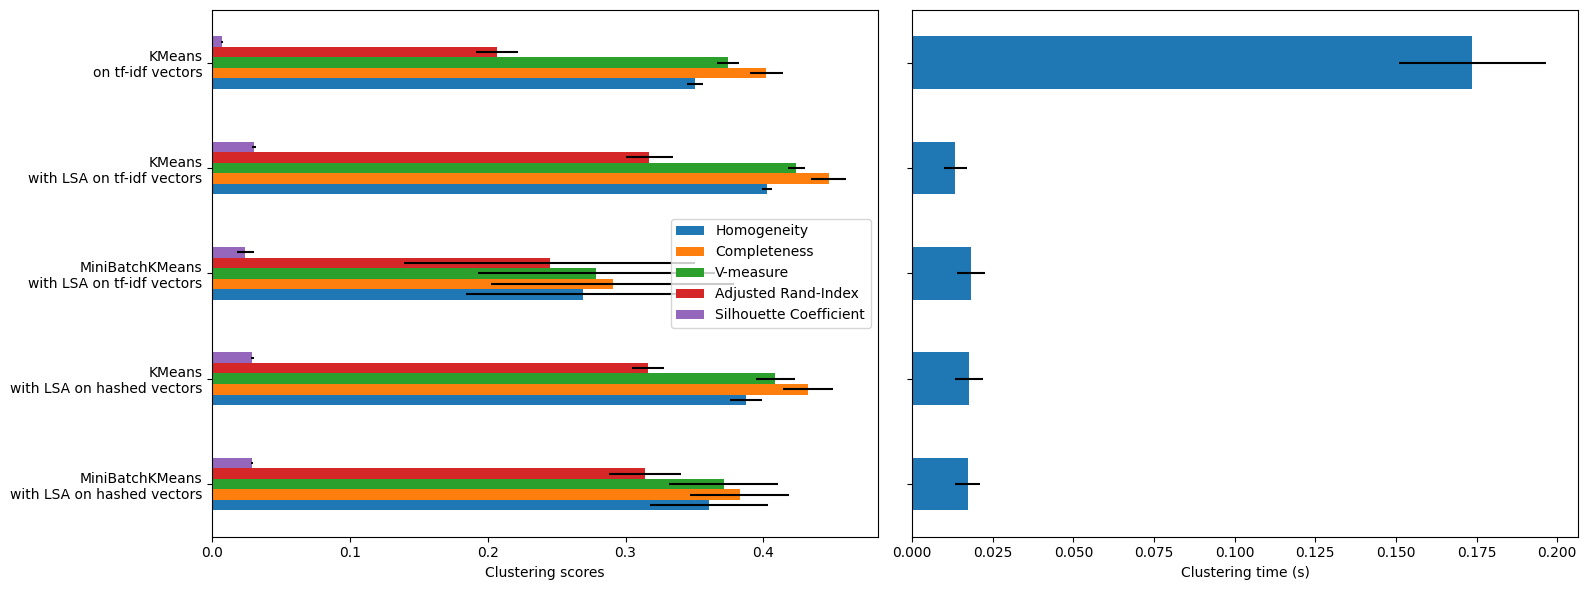

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df_eval = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std_eval = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df_eval.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std_eval)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df_eval["train_time"].plot.barh(ax=ax1, xerr=df_std_eval["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

### 6. <font color="red">Building a Classifier</font>

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


Format the Data

In [19]:
df_classify = df.drop(columns=["pred_target", "pred_target_names"])
df_classify.head(6)

,Text,act_target,act_target_names
0,My point is that you set up your views as the ...,0,alt.atheism
1,\nBy '8 grey level images' you mean 8 items of...,1,comp.graphics
2,FIRST ANNUAL PHIGS USER GROUP CONFERENCE\n\n ...,1,comp.graphics
3,"I responded to Jim's other articles today, but...",3,talk.religion.misc
4,"\nWell, I am placing a file at my ftp today th...",1,comp.graphics
5,\nI'm also interested in info both public doma...,1,comp.graphics


Score Models and Compare

In [22]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    # MultinomialNB(),
    LogisticRegression(random_state=0),
    CatBoostClassifier(iterations=5, learning_rate=0.1, verbose=True), #,loss_function='CrossEntropy' #verbose=True
    XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
    KNeighborsClassifier()
    
]

X_train, X_test, y_train, y_test = train_test_split(df_classify["Text"], 
                                                    df_classify["act_target"], 
                                                    test_size=0.3, 
                                                    random_state = 0)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)
X_train_tfidf = lsa_vectorizer.fit_transform(X_train)


## CHECK ON TRAIN DATA to Take Decision. Treat Test as Validation Set
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

0:	learn: 1.2840721	total: 33.6ms	remaining: 135ms
1:	learn: 1.2022098	total: 65.6ms	remaining: 98.3ms
2:	learn: 1.1277664	total: 99.1ms	remaining: 66.1ms
3:	learn: 1.0718362	total: 132ms	remaining: 33.1ms
4:	learn: 1.0214710	total: 168ms	remaining: 0us
0:	learn: 1.2925413	total: 47.7ms	remaining: 191ms
1:	learn: 1.2065696	total: 87ms	remaining: 131ms
2:	learn: 1.1374775	total: 126ms	remaining: 84ms
3:	learn: 1.0841179	total: 164ms	remaining: 40.9ms
4:	learn: 1.0291021	total: 203ms	remaining: 0us
0:	learn: 1.2674843	total: 51.5ms	remaining: 206ms
1:	learn: 1.1891146	total: 95.5ms	remaining: 143ms
2:	learn: 1.1191530	total: 137ms	remaining: 91.4ms
3:	learn: 1.0625861	total: 181ms	remaining: 45.4ms
4:	learn: 1.0142276	total: 234ms	remaining: 0us
0:	learn: 1.2647711	total: 47.3ms	remaining: 189ms
1:	learn: 1.1861139	total: 96.4ms	remaining: 145ms
2:	learn: 1.1162297	total: 146ms	remaining: 97.3ms
3:	learn: 1.0597602	total: 199ms	remaining: 49.7ms
4:	learn: 1.0074989	total: 248ms	remaining

model_name
CatBoostClassifier        0.712658
KNeighborsClassifier      0.716034
LinearSVC                 0.775105
LogisticRegression        0.775949
RandomForestClassifier    0.714768
XGBClassifier             0.709283
Name: accuracy, dtype: float64

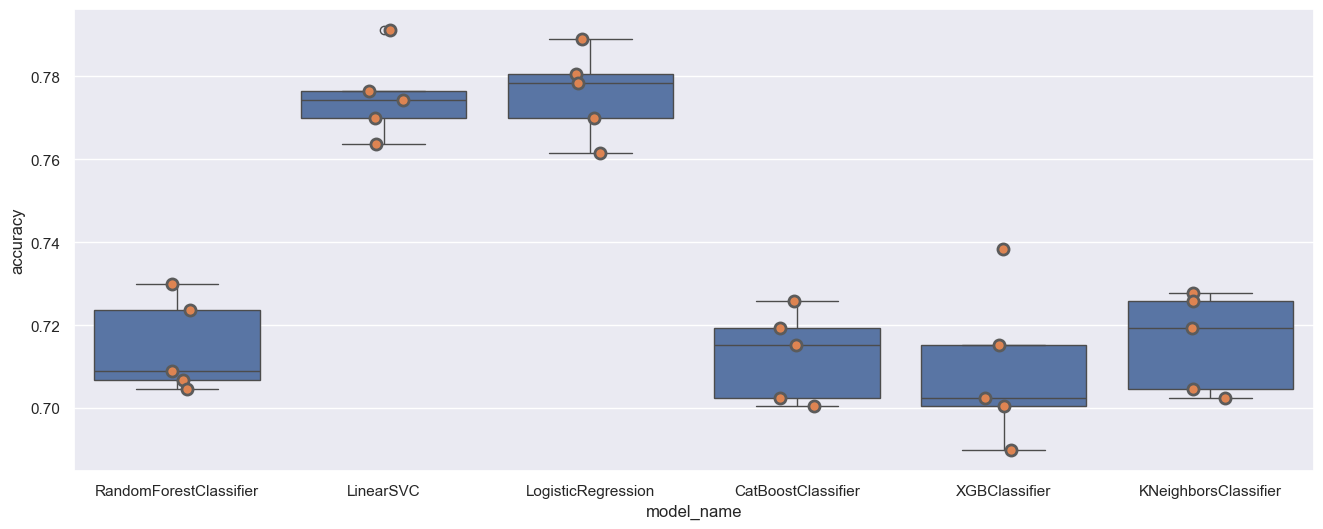

In [23]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(16,6)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
model = LinearSVC()
X_test_tfidf = lsa_vectorizer.fit_transform(X_test)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

How to Read the Conf Matrix :<br>
alt.atheism was correctly predicted in 88 records. 36 records of alt.atheism was predicted as graphics and so on

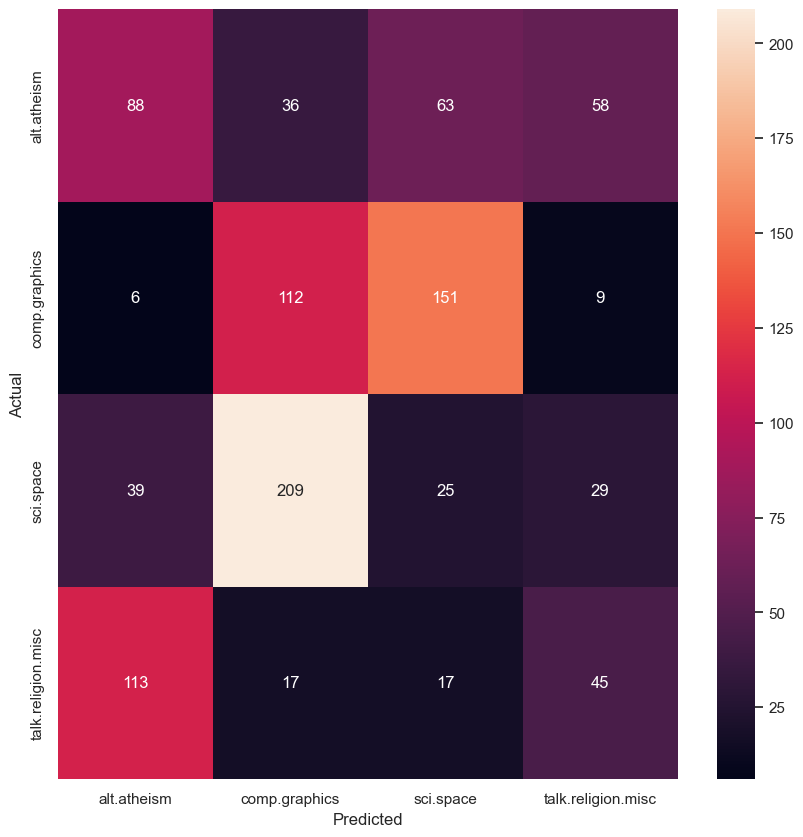

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=target_dict.values(), yticklabels=target_dict.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [48]:
test = pd.DataFrame(X_test, columns=["Text"])
test["y_act"] = y_test
test["y_pred"] = y_pred
test["y_act_label"] = list(map(lambda x : target_dict[x], y_test))
test["y_pred_label"] = list(map(lambda x : target_dict[x], y_pred))

test[test.y_act_label == "alt.atheism"].y_pred_label.value_counts()

y_pred_label
alt.atheism           88
sci.space             63
talk.religion.misc    58
comp.graphics         36
Name: count, dtype: int64

In [56]:
from sklearn import metrics

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(metrics.classification_report(y_test, y_pred, target_names=target_dict.values()))

accuracy 0.26548672566371684
                    precision    recall  f1-score   support

       alt.atheism       0.36      0.36      0.36       245
     comp.graphics       0.30      0.40      0.34       278
         sci.space       0.10      0.08      0.09       302
talk.religion.misc       0.32      0.23      0.27       192

          accuracy                           0.27      1017
         macro avg       0.27      0.27      0.27      1017
      weighted avg       0.26      0.27      0.26      1017



REF Links : <br>
Clustering : https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#k-means-clustering-on-text-features <br>
Matrix Decomposition : https://stackoverflow.com/questions/24169238/dealing-with-negative-values-in-sklearn-multinomialnb <br>